<img src="https://dhaka-ai.com/static/images/logo.png" align="center"/>

In this notebook I am going to show you how you can process the original dataset given for the [Dhaka.ai Challenge 2020](https://dhaka-ai.com/index) to train and generate submission files from the Starter Code given on the host site. As this is the first Machine Learning Comptition in Bangladesh, it will be a bit tough for the undergraduate students to catch up with bits and pieces of data pre processing in this object detection and localization competition. My notebook is for those who are willing to participate but don't have a deeper understanding of data pre-processing. Once you are able to run the basic train and submission, you can gradually study the starter code and tweak it to improve. Good Luck !


<br>
<br>

### Notebook Author:<br>

Md. Redwan Karim Sony<br>
Lecturer, Dept. of CSE,<br>
Islamic University of Technology [(IUT)](http://www.iutoic-dhaka.edu/) <br>
Email: [redwankarim@iut-dhaka.edu](mailto:redwankarim@iut-dhaka.edu)<br>
Kaggle: [@redwankarimsony](https://kaggle.com/redwankarimsony)

<br>
<br>

<h1>Table of Content:</h1>

1. [Data Download](#1)
2. [Data Cleaning](#2)
3. [Convert .xml to .txt](#3)
4. [Resizing all the Images](#4)
5. [Train and Validation Split](#5)
6. [Creating Metadata:](#6)
7. [Saving the Processed Dataset](#7)

<a id="1"></a>
##1. Data Download: 
First of all you need to download the original data hosted in the [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/POREXF) repository. For simplicity I just downloaded it and put it on my google drive. You can simply download the data and unzip it into an usable form just by running the follwoing cell of code.  

In [ ]:
from IPython.display import clear_output
import os, glob


# Downloading teh dataset
!gdown --id 1GIiqqmqEPSiGBb1MU1kIZG4q7BOIzqik
!unzip traffic-dataset.zip; rm traffic-dataset.zip;
clear_output()

# There was .rar file inside .zip file. So we unzip them again !
!unrar x train.rar
!unrar x test1.rar
clear_output()

# Removing rar files that we no longer need. 
!rm train.rar
!rm test1.rar

# Removing unnecessary demo data folder from workspace.
!rm -r sample_data

# Renaming raw data folder to remove space. Trust me, it makes life a lot easier :D 
%mv 'Final Train Dataset' train_data_raw


<a id="2"></a>
## 2. Data Cleaning:
At the time of initial coding, I found some problem with three of the images. They had two categories of problem. 
1. Train image files <font color="red">`Pias (359).PNG` </font> and <font color="red">`Pias (360).PNG` </font> are actually  `JPEG` files but somehow they are named with extention `.PNG`. So the height and width attribute in the corresponding xml labels are 0 as automatic label generator could not read the image properly. 

2. One of the label files <font color="red"> `231.xml` </font> is actually a `.txt` format label but labeled as `.xml` file. However for the inconsistency of the label index in that file, we will simply drop label and image together. 


To avoid the problem, simply we will remove these three problematic files and process rest of them. The follwoing code cell will remove them and their label file.


In [ ]:
corrupt_files = ['231.jpg', '231.xml', 'Pias (359).PNG','Pias (359).xml', 'Pias (360).PNG', 'Pias (360).xml']

%cd /content/train_data_raw/

for file in corrupt_files:
    file_path = os.path.join('/content/train_data_raw/', file)  
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f'{file} is removed successfully')
    else:
        print(f'{file} is already deleted')

%cd /content/

/content/train_data_raw
231.jpg is removed successfully
231.xml is removed successfully
Pias (359).PNG is removed successfully
Pias (359).xml is removed successfully
Pias (360).PNG is removed successfully
Pias (360).xml is removed successfully
/content


<a id="3"></a>
## 3. Convert .xml  to .txt
Now in the follwoing code cell, we define a function <font color ="blue"> `convert_xml2yolo()` </font> which will covert `.xml` format label file into `.txt` format file with the same name. 


Here is the required format of labels for YoLo V3: (for one image one text file)
* One row per object
* Each row is `class index` `x_center` `y_center` `width` `height` format describing a single bounding box. 
* Box coordinates must be in normalized `xywh format` from [0 - 1]. If your boxes are in pixels, divide `x_center` and `width` by `image_width`, and `y_center` and `height` by `image_height`.
* Class numbers are zero-indexed (start from 0).


The annotating process generates a text file for each image, contains the object class index and coordination for each object in it, as this format `(object-id) (x_centre) (y_centre) (width) (height)` in each line for each object. Coordinations values `(x_center, y_center, width, and height)` are relative to the width and the height of the image. Below are the formula for conversion. 

* $x\_center = \frac{(x\_min + x\_max) }{2(image\_height)}$
* $y\_center = \frac{(y\_min + y\_max) }{2(image\_width)}$
* $height = \frac{(x\_max - x\_min)}{(image\_height)}$
* $width = \frac{(y\_max - y\_min)}{(image\_width)}$

Where the image is denoted like: 

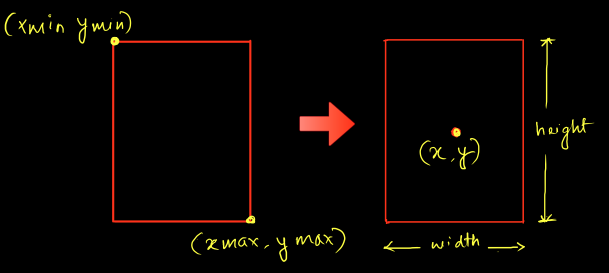

In [ ]:
"""
Thanks to @bjornstenger for his excellent code for converting the code from XML format to .txt format
here is the original link of this cell of code.
Original Link: https://github.com/bjornstenger/xml2yolo/blob/master/convert.py 
"""

from xml.dom import minidom

# Remember these number assigned. These are the label indexes which will be used in the training process.
# Feel free to unfold to see what's inside 

labels = ['ambulance',  'bicycle',  'bus',  'car',  'human hauler', 'minibus',
          'minivan', 'motorbike', 'pickup', 'policecar', 'rickshaw', 'scooter', 
          'suv', 'taxi', 'three wheelers (CNG)', 'truck', 'van', 'wheelbarrow']
          
lut = {}
for index, name in enumerate(labels):
    lut[name] = index


label_count ={}
removed_labels = []

print(f'Classes: {len(lut)} Object Names: {list(lut.keys())}' )

def convert_coordinates(size, box):
    """
    This function converts the coordinates. 
    box: (xmin, ymin, xmax, ymax)
    size: (width, height)

    returns a touple where (x, y, height, width) of the boundary box
    """
    dw = 1.0/size[0]
    dh = 1.0/size[1]
    x = (box[0]+box[1])/2.0
    y = (box[2]+box[3])/2.0
    w = box[1]-box[0]
    h = box[3]-box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


def convert_xml2yolo(filelist, lut ):
    """
    filelist: list of .xml file paths to convert to .txt file
    lut: a dictionary containing class_name to class_index mapping
    """
    for fname in filelist:
        xmldoc = minidom.parse(fname)
        fname_out = (fname[:-4]+'.txt')
        count = 0
        with open(fname_out, "w") as f:
            # print(f'processing{fname}')

            itemlist = xmldoc.getElementsByTagName('object')
            size = xmldoc.getElementsByTagName('size')[0]
            width = int((size.getElementsByTagName('width')[0]).firstChild.data)
            height = int((size.getElementsByTagName('height')[0]).firstChild.data)
            for item in itemlist:
                # get class label
                classid =  (item.getElementsByTagName('name')[0]).firstChild.data

                if classid in lut:
                    label_str = str(lut[classid])
                    count +=1
                    # get bbox coordinates
                    xmin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmin')[0]).firstChild.data
                    ymin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymin')[0]).firstChild.data
                    xmax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmax')[0]).firstChild.data
                    ymax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymax')[0]).firstChild.data
                    b = (float(xmin), float(xmax), float(ymin), float(ymax))
                    bb = convert_coordinates((width,height), b)
                    #print(bb)

                    label_count[classid] = label_count.get(classid, 0) + 1

                    f.write(label_str + " " + " ".join([("%.6f" % a) for a in bb]) + '\n')
                else:
                    label_str = "-1"
                    print(f'{classid} not found ')
                    
                    # print ("warning: label '%s' not in look-up table for file '%s'" % classid, fname )
    

        if count ==0:
            os.remove(fname_out)
            print(f'{fname_out } deleted as it has no labels')
            removed_labels.append(fname_out)
            
            os.remove(fname)
            image_path = glob.glob(fname_out[:-4]+ "*")[0]
            os.remove(image_path)
            print(f'{image_path } deleted as it has no labels') 


        # print ("wrote %s" % fname_out)

Classes: 18 Object Names: ['ambulance', 'bicycle', 'bus', 'car', 'human hauler', 'minibus', 'minivan', 'motorbike', 'pickup', 'policecar', 'rickshaw', 'scooter', 'suv', 'taxi', 'three wheelers (CNG)', 'truck', 'van', 'wheelbarrow']


Now Let us create the path list of the `.xml` files to convert them to `.txt` files. 

In [ ]:
# Reading Image file paths
formats = ['jpg', 'jpeg', 'JPG', 'png']
image_file_list = []
for format in formats:
    image_file_list.extend(glob.glob(f'/content/train_data_raw/*.{format}'))

# Reading XML label file paths
label_file_list_xml = glob.glob('/content/train_data_raw/*.xml')

print(f'Image files found: {len(image_file_list)} \nLabel files found: { len(label_file_list_xml)}')

Image files found: 3000 
Label files found: 3000


In [ ]:
# Converting .xml file to .txt file
convert_xml2yolo(label_file_list_xml, lut)
label_file_list_txt = glob.glob('/content/train_data_raw/*.txt')
print(f'XML --> TXT files: {len(label_file_list_txt)}')

auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
/content/train_data_raw/Dipto_ 241.txt deleted as it has no labels
/content/train_data_raw/Dipto_ 241.jpg deleted as it has no labels
garbagevan not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
auto rickshaw not found 
army vehicle not found 
army vehicle not found 
auto rickshaw not fou

In [ ]:
print(removed_labels)
label_count

['/content/train_data_raw/Dipto_ 241.txt', '/content/train_data_raw/Dipto_769.txt', '/content/train_data_raw/Dipto_674.txt', '/content/train_data_raw/Dipto_768.txt', '/content/train_data_raw/Dipto_ 104.txt']


{'ambulance': 70,
 'bicycle': 459,
 'bus': 3333,
 'car': 5476,
 'human hauler': 169,
 'minibus': 95,
 'minivan': 934,
 'motorbike': 2284,
 'pickup': 1225,
 'policecar': 32,
 'rickshaw': 3536,
 'scooter': 38,
 'suv': 859,
 'taxi': 60,
 'three wheelers (CNG)': 2989,
 'truck': 1492,
 'van': 756,
 'wheelbarrow': 119}

## Data Visualization: 
Let us have a look at the existance of the labels in the dataset. 

In [ ]:
import pandas as pd
import plotly.express as px

# DataFrame Generation
def plot_label_count(label_count):
    df = pd.DataFrame({'labels': label_count.keys(), 'count': label_count.values()})
    df.columns = ['labels', 'count']
    df.sort_values(['count'], ascending = False, inplace =True)
    df.head()

    # Plotting
    fig = px.bar(df, x="labels", y='count',  color="count",
        orientation='v', 
        title='Frequency of the Labels in Dhaka.ai-2020 Challenge', 
        color_continuous_scale=px.colors.sequential.Viridis_r
    )
    fig.update_layout(title_x=0.5, xaxis_title = 'Labels', yaxis_title = 'Label Count')
    fig.update_xaxes(tickangle=60)
    fig.show()

plot_label_count(label_count)

<a id="4"></a>
## 4. Resizing all the Images
If you observe carefully, you will see that images have different sizes. They are not uniform. The following code segment visualizes that nicely.  <font color="red">It seems that 3000 images has 430 different resolutins. </font> Here the follwoing segment of code shows that we have some high resolution images which we have to downsampled to $(1024x1024)$ and some images which have lower resolution than $(1024x1024)$ should be upsampled. 

😃😃😃 <font color="green"> Since yolo v3 uses relative bounding box parameters, we changing the aspect ration will have no effect on the bounding box placement. So we dont have to change the labels after we resize the images.  </font>

In [ ]:
from PIL import Image
img_sizes = {}

# Reading Image file paths
formats = ['jpg', 'jpeg', 'JPG', 'png']
image_file_list = []
for format in formats:
    image_file_list.extend(glob.glob(f'/content/train_data_raw/*.{format}'))
    

for fname in image_file_list:
    img = Image.open(fname)
    img_sizes[img.size] = img_sizes.get(img.size, 0) +1 
img_sizes

{(352, 399): 1,
 (352, 401): 1,
 (352, 404): 1,
 (352, 405): 1,
 (352, 421): 1,
 (352, 426): 1,
 (352, 429): 1,
 (352, 432): 1,
 (352, 435): 1,
 (352, 436): 2,
 (352, 437): 1,
 (352, 438): 1,
 (352, 439): 2,
 (352, 443): 1,
 (352, 444): 1,
 (352, 445): 1,
 (352, 448): 1,
 (352, 454): 1,
 (352, 456): 1,
 (352, 458): 1,
 (352, 460): 1,
 (352, 461): 1,
 (352, 462): 1,
 (352, 467): 1,
 (352, 469): 2,
 (352, 472): 1,
 (352, 476): 1,
 (352, 478): 1,
 (352, 479): 3,
 (352, 486): 1,
 (352, 488): 1,
 (352, 490): 1,
 (352, 491): 1,
 (352, 492): 1,
 (352, 493): 1,
 (352, 496): 1,
 (352, 498): 1,
 (352, 502): 1,
 (352, 506): 2,
 (352, 507): 1,
 (352, 509): 1,
 (352, 511): 2,
 (352, 512): 1,
 (352, 515): 1,
 (352, 517): 1,
 (352, 524): 1,
 (352, 526): 1,
 (352, 527): 1,
 (352, 537): 1,
 (352, 543): 2,
 (352, 545): 1,
 (352, 547): 1,
 (352, 586): 1,
 (407, 539): 1,
 (431, 576): 1,
 (451, 587): 1,
 (490, 654): 1,
 (491, 654): 1,
 (491, 656): 1,
 (492, 655): 1,
 (530, 667): 1,
 (540, 359): 1,
 (560, 7

In [ ]:
def resize_images(file_list, width = 1024, height = 1024, overwrite = True, save_dir = ''):
    total_files = len(file_list)
    idx = 1
    for path in file_list:
        img = Image.open(path)
        img_resized = img.resize((width, height))
        if overwrite:
            img_resized.save(path)
            filename = path.split('/')[-1] 
            print(f"{idx}/{total_files}: {filename} {img.size}--> ({width}x{height})")
        else:
            filename = path.split('/')[-1]
            img_resized.save(save_dir + filename)
            print(f'{filename} saved to {save_dir}')
        idx +=1
    clear_output()

In [ ]:
resize_images(image_file_list,  width = 640, height = 640, overwrite= True)

We don't have to resize the test images because they are already resized to our desired format. 

In [ ]:
# Reading Image file paths
formats = ['jpg', 'jpeg', 'JPG', 'png']
image_file_list = []
for format in formats:
    image_file_list.extend(glob.glob(f'/content/train_data_raw/*.{format}'))
len(image_file_list)

2995




<a id="5"></a>
## 5. Train and Validation Split
For training the model and evaluating at the same time, we will split the whole training dataset into a train and validation set. We will be using $80-20$ dividion rule for the train and validation split. 

In [ ]:
import random
random.seed(1455)

#randomply selecting the index of the files
valid_set_index = random.sample(range(len(image_file_list)), 600)
len(set(image_file_list)), len(set(label_file_list_txt)), len(valid_set_index)

image_file_list = sorted(image_file_list)
label_file_list_txt = sorted(label_file_list_txt)

# sanity check of the image files and labels being in the same order
print('Checking files concurrency')
print(image_file_list[:5])
print(label_file_list_txt[:5])

# code to separate train and validation set
valid_selected_images = []
valid_selected_labels = []

for index in valid_set_index: 
    valid_selected_images.append(image_file_list[index])
    valid_selected_labels.append(label_file_list_txt[index])


print('\n\nChecking files concurrency in validation set')
print(valid_selected_images[:5])
print(valid_selected_labels[:5])

Checking files concurrency
['/content/train_data_raw/01.jpg', '/content/train_data_raw/02.jpg', '/content/train_data_raw/03.jpg', '/content/train_data_raw/04.jpg', '/content/train_data_raw/05.jpg']
['/content/train_data_raw/01.txt', '/content/train_data_raw/02.txt', '/content/train_data_raw/03.txt', '/content/train_data_raw/04.txt', '/content/train_data_raw/05.txt']


Checking files concurrency in validation set
['/content/train_data_raw/Numan_(340).jpg', '/content/train_data_raw/102.jpg', '/content/train_data_raw/37.jpg', '/content/train_data_raw/Navid_305.jpg', '/content/train_data_raw/Dipto_696.jpg']
['/content/train_data_raw/Numan_(340).txt', '/content/train_data_raw/102.txt', '/content/train_data_raw/37.txt', '/content/train_data_raw/Navid_305.txt', '/content/train_data_raw/Dipto_696.txt']


In [ ]:
import shutil

# Creating validation directory
valid_dir = '/content/valid/'

if os.path.exists(valid_dir):
    print(f'Directory {valid_dir} already exists !')
else: 
    os.makedirs(valid_dir)
    print(f"Directory {valid_dir} is created successfully!") 


for idx in range(len(valid_selected_images)):
    # moving image files
    mypath = valid_selected_images[idx]
    if os.path.exists(mypath):
        filename = mypath.split('/')[-1]
        shutil.move(mypath , valid_dir + filename)
    else:
        print(f'{mypath} not found')
        
    # moving label files
    mypath = valid_selected_labels[idx]
    if os.path.exists(mypath):
        filename = mypath.split('/')[-1]
        shutil.move(mypath , valid_dir + filename)
    else:
        print(f'{mypath} not found')

Directory /content/valid/ is created successfully!


Now the remaining images in the `train_data_raw` are actually the train directory. We will rename it to `train`

In [ ]:
!mv train_data_raw train  

<a id="6"></a>
## 6. Creating Metadata:
The strter code has some files as metadata. We need to produce contents for them. We have to produce the follwoing files. 
* `train.txt` : A text file containing full paths of all the training image files. 
* `valid.txt` : A text file containing full paths of all the validation image files
* `test.txt` :  A text file containing full paths of all the test image files
* `traffic.names`: A text file containing all the traffic label names line by line
* `traffic.data`: Its a confguration file that stores the number of classes, and the location of train.txt and valid.txt for training purpose

In [ ]:
!rm -r /content/metadata

In [ ]:
def lookup_image_file_paths(formats, dir):
    """
    This function takes a specified set of formats and directory address to list all the filepaths
    of the desired format in that directory
    """
    filepaths = []
    for format in formats:
        filepaths.extend(glob.glob(f'{dir}*.{format}'))
    return filepaths

def make_txt_file(formats, dir):
    """
    Formats the file names to write in the desired txt file
    """
    filepaths = lookup_image_file_paths(formats, dir)
    
    filenames = [x.split('/')[-1] for x in filepaths]
    txt_file_name = dir.split('/')[-2]

    print(f'{txt_file_name} : {len(filepaths)} images')
    with open(f'/content/{txt_file_name}.txt', 'w') as outfile:
        for filename in filenames:
            outfile.write(f'data/{txt_file_name}/'+filename+'\n')
        outfile.close()


In [ ]:
train_dir = '/content/train/'
valid_dir = '/content/valid/'
test_dir =  '/content/test/'

# Making the .txt file containing list of images. 
make_txt_file(formats, dir = train_dir)
make_txt_file(formats, dir = test_dir)
make_txt_file(formats, dir = valid_dir)

# Writing the file traffic.names
object_labels = list(lut.keys())
with open('/content/traffic.names', 'w') as outfile:
    for label in object_labels:
        outfile.write(label + '\n')
    outfile.close()

# Writing the file traffic.data
data_config = f'classes={len(labels)}\ntrain=train.txt\nvalid=valid.txt\nnames=traffic.names'
with open('/content/traffic.data', 'w') as outfile:
    outfile.write(data_config + '\n')
    outfile.close()

train : 2395 images
test : 500 images
valid : 600 images


<a id="7"></a>
## 7. Saving the Processed Dataset:
Now our dataset is ready for using with the starter code given at the host site. But before that we need to save the processed dataset in google drive so that we can later use it in the Starter Code. 

<font color='red'> Now mount your google drive here so that you can export the processed `dhaka-traffic-yolo-v3.zip` to your drive for later use </font> Or you can just download it and again re upload it to the Starter Notebook in Google Colab. 

In [ ]:
!zip -r dhaka-traffic-yolo-v5_18_class_640.zip train test valid train.txt valid.txt test.txt traffic.data traffic.names traffic.yaml
clear_output()

In [ ]:
!cp /content/dhaka-traffic-yolo-v5_18_class_640.zip '/content/drive/My Drive/Dhaka-ai'

Now we are done with pre-processing the data and we are ready to put the whole dataset to the training of Yolo V3 in the Starter Code given on the host website. 

Thank you and good luck!







In [ ]:
train_label_files = glob.glob('/content/train/*txt')
valid_label_files = glob.glob('/content/valid/*txt')

In [ ]:
def count_labels_from_txts(filelist, labels):
    count_dic = {}
    for file in filelist:
        with open(file, 'r') as f:
            for line in f:
                label_name = labels[int(line.split(' ')[0] )]
                count_dic[label_name] = count_dic.get(label_name, 0)+1
    return count_dic


In [ ]:
train_label_count = count_labels_from_txts(train_label_files, labels)
valid_label_count = count_labels_from_txts(valid_label_files, labels)


In [ ]:
plot_label_count(train_label_count)

In [ ]:
plot_label_count(valid_label_count)